In [65]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy 
from scipy import stats

In [66]:
def get_coul_vdW_lambdas(mdpfile):
    """Given an *.mdp file as input, extract the values of coul-lambdas and vdw-lambdas
    
    RETURNS
    coul_lambdas    - numpy array of coul-lambdas
    vdw_lambdas     - numpy array of vdw-lambdas
    
    NOTE: for the Moonshot2 alchemical transformations, the lambda=0 state is fully coupled, 
          and lambda=1 is fully uncoupled:
          
              couple-lambda0         = vdw-q
              couple-lambda1         = none
              
          That means that *first* the coulomb gets turned off, *then* the vdW:
          
    coul-lambdas         = 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0 1.000 1.000 1.000 1.000 ... 1.000 1.0
    vdw-lambdas          = 0.0 0.000 0.000 0.000 0.000 ... 0.000 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0
    """
        
    fin = open(mdpfile,'r')
    lines = fin.readlines()
    fin.close()
    
    coul_lambdas, vdw_lambdas = None, None
    
    for line in lines:
        if line.count('coul-lambdas'):
            coul_string = line.split('=')[1].strip()
            # print('coul_string', coul_string)
            coul_lambdas = np.array([float(s) for s in coul_string.split()])
            # print('coul_lambdas', coul_lambdas)
        elif line.count('vdw-lambdas'):
            vdw_string = line.split('=')[1].strip()
            # print('vdw_string', vdw_string)
            vdw_lambdas = np.array([float(s) for s in vdw_string.split()])

    return coul_lambdas, vdw_lambdas

In [67]:
# Let's try this for an example:
mdpfile = '../x11294_L/RUN0/prod.mdp'
coul_lambdas, vdw_lambdas = get_coul_vdW_lambdas(mdpfile)
# print('coul_lambdas', coul_lambdas)
# print('vdw_lambdas', vdw_lambdas)

# We map each [0,1] set of values to the interval [0,2] by summing the two
lambdas = coul_lambdas + vdw_lambdas
print('lambdas', lambdas)
print('lambdas.shape', lambdas.shape)


lambdas [0.    0.02  0.04  0.061 0.081 0.102 0.122 0.142 0.163 0.183 0.204 0.224
 0.244 0.265 0.285 0.306 0.326 0.346 0.367 0.387 0.408 0.428 0.448 0.469
 0.489 0.51  0.53  0.551 0.571 0.591 0.612 0.632 0.653 0.673 0.693 0.714
 0.734 0.755 0.775 0.795 0.816 0.836 0.857 0.877 0.897 0.918 0.938 0.959
 0.979 1.    1.    1.02  1.04  1.061 1.081 1.102 1.122 1.142 1.163 1.183
 1.204 1.224 1.244 1.265 1.285 1.306 1.326 1.346 1.367 1.387 1.408 1.428
 1.448 1.469 1.489 1.51  1.53  1.551 1.571 1.591 1.612 1.632 1.653 1.673
 1.693 1.714 1.734 1.755 1.775 1.795 1.816 1.836 1.857 1.877 1.897 1.918
 1.938 1.959 1.979 2.   ]
lambdas.shape (100,)


In [68]:
def get_dhdl_data(dhdl_xvgfile, verbose=True):
    """Read and parse the information in the dhdl file.
    
    RETURNS
    time_in_ps      - time in ps (1D np.array)
    thermo_states   - thermodynamic state indices (1D np.array)
    dhdl            - delta_Uij (np.array of shape (N,K))
                      where N is snapshots and K is number of thermodynamic states
    
    NOTES
    
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\\xl\\f{} fep-lambda = 0.0000"
                      Column 4 = @ s3 legend "dH/d\\xl\\f{} coul-lambda = 0.0000"
                      Column 5 = @ s4 legend "dH/d\\xl\\f{} vdw-lambda = 0.0000"
    dU_ij starts      Column 6 = @ s5 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0000, 0.0000)"
                      Column 7 = @ s6 legend "\\xD\\f{}H \\xl\f{} to (0.0000, 0.0200, 0.0000)"
                      Column 8 = @ s7 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0400, 0.0000)"
    """
    
    
    import os
    assert os.path.exists(dhdl_xvgfile)
    
    # Read and parse the file
    fin = open(dhdl_xvgfile,'r')
    lines = fin.readlines()
    fin.close()
    
    dhdl_column_start = None
    # Read to headers to find which column starts the dhdl data
    for line in lines:
        # Looking for line like this: "@ s5 legend "\xD\f{}H \xl\f{} to (0.0000, 0.0000, 0.0000)"
        if line.count('"\\xD\\f{}H') > 0:
            dhdl_column_start = int(line.split(' ')[1].replace('s','')) + 1
            break
    if verbose:
        print('dhdl data starts at column:', dhdl_column_start)

    # Get rid of all the header lines
    i = 0
    while i < len(lines):
        if (lines[i][0] == '#') or (lines[i][0] == '@'):
            lines.pop(i)
        else:
            i+=1
    
    # find the correct number of entries from the first line
    ncols = len(lines[0].strip().split())
    print(lines[0])
    print('ncols', ncols)
    
    time_in_ps, dhdl, thermo_states = [], [], []
    for line in lines:
        line_data_list = [float(s) for s in line.strip().split()] 
            
        # Skip line if it doesn't have the correct number of entries
        # (sometimes the I/O gets cutoff when writing the dhdl.xvg in it corrupts the data)
        if len(line_data_list) == ncols:
            time_in_ps.append(line_data_list[0])
            thermo_states.append(line_data_list[1])
            dhdl.append(line_data_list[dhdl_column_start:])
            
    time_in_ps = np.array(time_in_ps)
    dhdl = np.array(dhdl)
    thermo_states = np.array(thermo_states)
    
    print('time_in_ps.shape', time_in_ps.shape)
    print('dhdl.shape=', dhdl.shape)
    print('thermo_states=', thermo_states)

    return time_in_ps, thermo_states, dhdl


###############
    
    
dhdl_xvgfile = '../x11294_L/RUN0/dhdl.xvg'
time_in_ps, thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile)
print('time_in_ps', time_in_ps)
print('thermo_states', thermo_states)
print('dhdl', dhdl)


dhdl data starts at column: 6
0.0000    0 -46556.051 0.0000000 83.339630 27.333431 0.0000000 1.6666951 3.3338471 5.0838019 6.7505383 8.5007701 10.167665 11.834328 13.584350 15.251400 17.001263 18.668061 20.334800 22.085112 23.751836 25.502085 27.168654 28.835488 30.585740 32.252561 34.002686 35.669449 37.336258 39.086318 40.753137 42.503203 44.170075 45.920240 47.587044 49.253793 51.003890 52.670746 54.420890 56.087597 57.754407 59.504574 61.171429 62.921453 64.588241 66.255116 68.005214 69.672013 71.422139 73.088914 74.755697 76.505856 78.172638 79.922778 81.589565 83.339700 83.339700 83.946801 84.668351 85.539265 86.468100 87.539496 88.644340 89.825379 91.141285 92.461368 93.912387 95.351669 96.842827 98.460381 100.04676 101.75713 103.42560 105.12995 106.95543 108.72578 110.61572 112.44316 114.29558 116.26564 118.16404 120.17900 122.11716 124.17091 126.14337 128.13083 130.23262 132.24754 134.37605 136.41454 138.46327 140.62458 142.69191 144.87123 146.95432 149.04417 151.24517 153.347

Next, we estimate the sigmas from the dhdl data

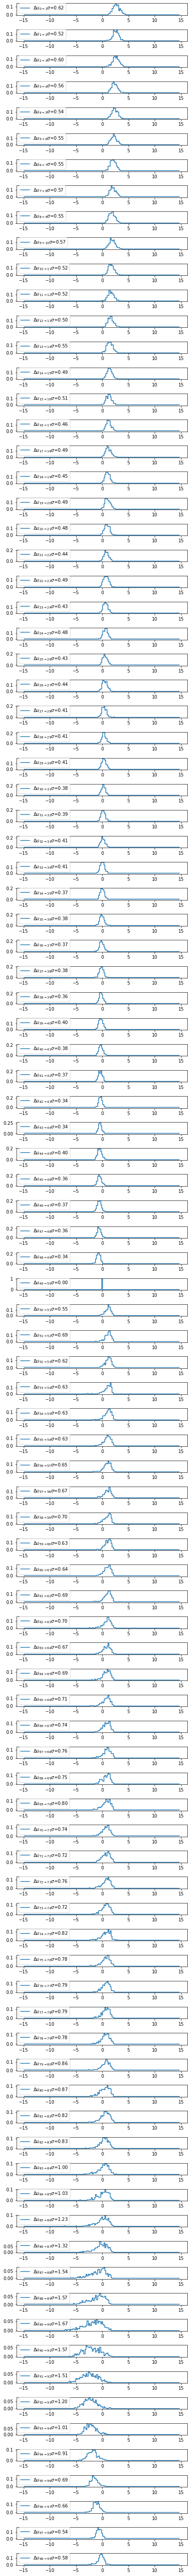

In [69]:
def estimate_sigmas(dhdl, thermo_states, plot_data=True):
    """Using as input the Delta_U_ij energies from the dhdl array, 
    estimate the standard deviations P(U_{i-->i+1}) for neighboring ensembles.
    
    RETURNS
    sigmas   - a list of standard deviations P(U_{i-->i+1}).
    """
    
    nlambdas = dhdl.shape[1]
    
    if plot_data:
        plt.figure(figsize=(6, 80))

    Delta_uij_values = []     
    sigmas = []
       
    for j in range(nlambdas-1):
    
        ##transitions from state 0 to 1 or 1 to 2, or 2 to 3 .... 
        Ind_i = (thermo_states == j)
        delta_u_ij = dhdl[Ind_i, j+1]       ##only for neighbored ensembles

        #Delta_uij_values.append(delta_u_ij)

        mu, sigma = scipy.stats.norm.fit(delta_u_ij)
        #print (mu, sigma)
        sigmas.append(sigma)

        delta_u_bins = np.arange(-15., 15., 0.2)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        if plot_data:
            plt.subplot(nlambdas-1, 1, j+1)
            plt.step(bin_centers, counts, label='$\Delta u_{%d \\rightarrow %d} \sigma$=%.2f'%(j,j+1,sigma))
            #plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j, j+1))
            plt.legend(loc='best')
        
    if plot_data:
        plt.tight_layout()
        plt.show()

    return sigmas

##################

sigmas = estimate_sigmas(dhdl, thermo_states, plot_data=True)

In [70]:
# For *THIS* particular data set we can see there is a problem:
# The i=49 --> i+1 = 50 lambdas are the same, resulting in a sigma of zero for that transition
# Let's remove it

remove_index = 49
# print('sigmas', sigmas)
sigmas.pop(remove_index)
# print('FIXED sigmas', sigmas)

print('lambdas',lambdas)
print('lambdas.shape',lambdas.shape)
lambdas_list = lambdas.tolist()
lambdas_list.pop(remove_index)
lambdas = np.array(lambdas_list)
print('FIXED lambdas',lambdas)
print('FIXED lambdas.shape',lambdas.shape)

lambdas [0.    0.02  0.04  0.061 0.081 0.102 0.122 0.142 0.163 0.183 0.204 0.224
 0.244 0.265 0.285 0.306 0.326 0.346 0.367 0.387 0.408 0.428 0.448 0.469
 0.489 0.51  0.53  0.551 0.571 0.591 0.612 0.632 0.653 0.673 0.693 0.714
 0.734 0.755 0.775 0.795 0.816 0.836 0.857 0.877 0.897 0.918 0.938 0.959
 0.979 1.    1.    1.02  1.04  1.061 1.081 1.102 1.122 1.142 1.163 1.183
 1.204 1.224 1.244 1.265 1.285 1.306 1.326 1.346 1.367 1.387 1.408 1.428
 1.448 1.469 1.489 1.51  1.53  1.551 1.571 1.591 1.612 1.632 1.653 1.673
 1.693 1.714 1.734 1.755 1.775 1.795 1.816 1.836 1.857 1.877 1.897 1.918
 1.938 1.959 1.979 2.   ]
lambdas.shape (100,)
FIXED lambdas [0.    0.02  0.04  0.061 0.081 0.102 0.122 0.142 0.163 0.183 0.204 0.224
 0.244 0.265 0.285 0.306 0.326 0.346 0.367 0.387 0.408 0.428 0.448 0.469
 0.489 0.51  0.53  0.551 0.571 0.591 0.612 0.632 0.653 0.673 0.693 0.714
 0.734 0.755 0.775 0.795 0.816 0.836 0.857 0.877 0.897 0.918 0.938 0.959
 0.979 1.    1.02  1.04  1.061 1.081 1.102 1.122 1.142 

## Lambda optimization

In [71]:
dx = sigmas                 #according to Vince's equation (VAV: k is set to 1)
#print (dx, len(dx))

x_values = np.cumsum(dx)    # convert to a list of x values
x_values = np.array(np.concatenate([[0], x_values]))    # add a zero corresponding to lambda0 = 0.0
## VAV: This zero needs to be included.  Why was this left out before?
print('x_values', x_values)

x_values [ 0.          0.61566532  1.13414681  1.73190516  2.29383929  2.83822016
  3.3901718   3.94312792  4.51390358  5.05906149  5.62772415  6.14449683
  6.66932419  7.17187093  7.72081489  8.21016302  8.71801816  9.18060569
  9.67303878 10.12779997 10.6183442  11.09654343 11.53443873 12.02077092
 12.45447796 12.93643343 13.36405035 13.80880346 14.22253015 14.63545121
 15.0501461  15.42800588 15.820026   16.22606493 16.63111583 17.00561409
 17.3895208  17.75956424 18.13885361 18.49416141 18.89169578 19.27194472
 19.64070934 19.97663634 20.31884469 20.71680613 21.08091761 21.45140911
 21.80709077 22.15042611 22.70371117 23.38883442 24.00901393 24.63402759
 25.26411233 25.88976871 26.54389549 27.21747859 27.92187496 28.54849498
 29.1852846  29.87430272 30.57551959 31.24768282 31.93369086 32.64587223
 33.38978554 34.15227527 34.9027263  35.70750357 36.44967776 37.171178
 37.92863303 38.64807663 39.46460385 40.24008638 41.02630492 41.81512266
 42.59341423 43.45369759 44.32255821 45.1408

No handles with labels found to put in legend.


Text(0.5, 0, 'lambda')

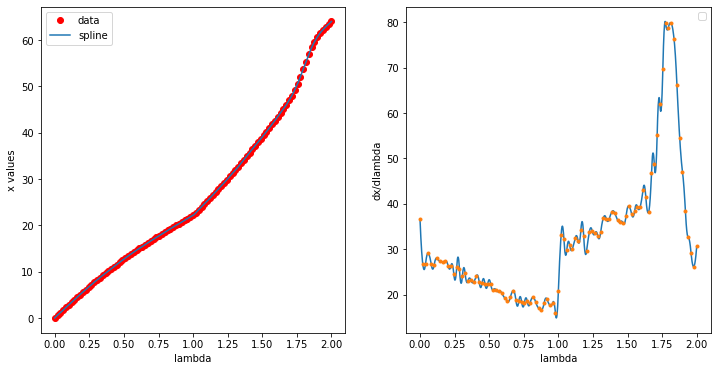

In [83]:

from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
plt.figure(figsize=(12,6))

lambda_values = lambdas #not inclduing the first one, lambda_0 

x_observed = lambda_values      #not inclduing the first one, lambda_0
y_observed = x_values

plt.subplot(1,2,1)
plt.plot(x_observed, y_observed, 'ro', label = 'data')
#plt.semilogy(x_observed, y_observed, 'ro', label = 'data')

#y_spl = CubicSpline(x_observed, y_observed)#, s=0,k=4)  
y_spl = UnivariateSpline(x_observed, y_observed, s=0, k=3)  
x_range = np.linspace(x_observed[0], x_observed[-1], 1000)
plt.plot(x_range, y_spl(x_range), label="spline")   # for UnivariateSpline
## plt.plot(x_observed, y_spl(x_observed), label="spline") # for CubicSpline
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')

plt.subplot(1,2, 2)   #derivative plot
y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
#print (y_spl_1d(x_observed))
# y_spl_1d = y_spl(x_observed, 1)  # first derivative of Cubic spline


plt.plot(x_range, y_spl_1d(x_range), '-')
plt.plot(x_observed, y_spl_1d(x_observed), '.')
plt.ylabel('dx/dlambda')

#plt.plot(x_observed, y_spl_1d, '.-', label='derivative')
plt.legend()
plt.xlabel('lambda')

lambda_values [0.    0.02  0.04  0.061 0.081 0.102 0.122 0.142 0.163 0.183 0.204 0.224
 0.244 0.265 0.285 0.306 0.326 0.346 0.367 0.387 0.408 0.428 0.448 0.469
 0.489 0.51  0.53  0.551 0.571 0.591 0.612 0.632 0.653 0.673 0.693 0.714
 0.734 0.755 0.775 0.795 0.816 0.836 0.857 0.877 0.897 0.918 0.938 0.959
 0.979 1.    1.02  1.04  1.061 1.081 1.102 1.122 1.142 1.163 1.183 1.204
 1.224 1.244 1.265 1.285 1.306 1.326 1.346 1.367 1.387 1.408 1.428 1.448
 1.469 1.489 1.51  1.53  1.551 1.571 1.591 1.612 1.632 1.653 1.673 1.693
 1.714 1.734 1.755 1.775 1.795 1.816 1.836 1.857 1.877 1.897 1.918 1.938
 1.959 1.979 2.   ]
step 0 del_lambdas 7.629951035289084e-05
step 250 del_lambdas 1.4263582242330821e-05
step 500 del_lambdas 1.0900463427536906e-05
step 750 del_lambdas 1.0596324472273011e-05
step 1000 del_lambdas 1.0164716575200943e-05
step 1250 del_lambdas 9.760140591502632e-06
step 1500 del_lambdas 9.424885285167725e-06
step 1750 del_lambdas 9.122733663046998e-06
step 2000 del_lambdas 8.81421186

Text(0, 0.5, 'x values')

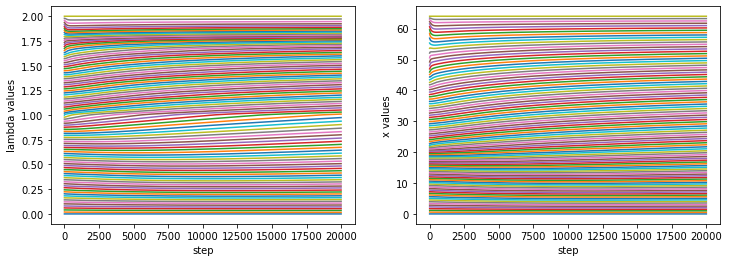

In [95]:
# Let's try a steepest descent algorithm like the kind I wrote up in "math-gradient-descent-2021-05-07.pdf"

# run the algorithm some fixed number of steps, or until some tolerance is reached
nsteps = 20000
tol = 1e-7  # stop if the lambdas dont change within this tolerance

alpha = 2e-5  # gradient descent step size

VERBOSE = False
print_every = 250

nlambdas = len(lambda_values)
print('lambda_values', lambda_values)
old_lambdas = np.array(lambda_values)
traj_lambdas = np.zeros( (nlambdas,nsteps) )
for step in range(nsteps):

    # store the trajectory of lambdas
    traj_lambdas[:,step] = old_lambdas
    if VERBOSE:
        print('step', step, old_lambdas)
    
    # perform a steepest descent step
    new_lambdas = np.zeros( old_lambdas.shape )
    new_lambdas[0] = old_lambdas[0]  # fix the \lambda = 0 endpoint
    for i in range(1, (nlambdas-1)):
        new_lambdas[i] = old_lambdas[i] - alpha*2.0*y_spl_1d(old_lambdas[i])*( 2.0*y_spl(old_lambdas[i]) - y_spl(old_lambdas[i-1]) - y_spl(old_lambdas[i+1]))
    new_lambdas[nlambdas-1] = old_lambdas[nlambdas-1]  # fix the \lambda = 1 endpoint
    
    # record the average change in the lambdas 
    del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
    if step % print_every == 0:
        print('step', step, 'del_lambdas', del_lambdas)
    if del_lambdas < tol:
        print('Tolerance has been reached: del_lambdas =', del_lambdas, '< tol =', tol)
        break
        
    old_lambdas = new_lambdas
    
# Plot the results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(nlambdas):
    plt.plot(range(step), traj_lambdas[i,0:step], '-')
plt.xlabel('step')
plt.ylabel('lambda values')

plt.subplot(1,2,2)
for i in range(nlambdas):
    plt.plot(range(step), y_spl(traj_lambdas[i,0:step]), '-')
plt.xlabel('step')
plt.ylabel('x values')

new_lambdas [0.         0.0159732  0.03535875 0.05365203 0.07120446 0.09013131
 0.10939825 0.12759796 0.14607839 0.16482053 0.18350728 0.20231823
 0.22210873 0.24151931 0.26302556 0.28180201 0.30358692 0.32414134
 0.34649867 0.36880066 0.39189488 0.4141425  0.43713617 0.46076071
 0.48502299 0.50870824 0.53411342 0.56016    0.58690329 0.61509219
 0.64528479 0.67386523 0.70358091 0.73485283 0.76756049 0.80066174
 0.83248269 0.86786564 0.90418357 0.93850095 0.97478857 1.01001173
 1.03031349 1.05123122 1.07344831 1.09550221 1.11759944 1.13844171
 1.15993465 1.17945099 1.20211461 1.22408794 1.24436158 1.26537396
 1.28637121 1.30796808 1.32777131 1.34695849 1.36669112 1.3858692
 1.40465828 1.42399845 1.44405784 1.46421486 1.48464846 1.50382303
 1.52254506 1.5421399  1.56132072 1.58015985 1.59906494 1.61670094
 1.63398776 1.65327668 1.67150265 1.68661751 1.7020978  1.71673713
 1.72891959 1.74113335 1.75309917 1.7634157  1.77291079 1.78242341
 1.79204943 1.80159708 1.81105694 1.82052586 1.8301

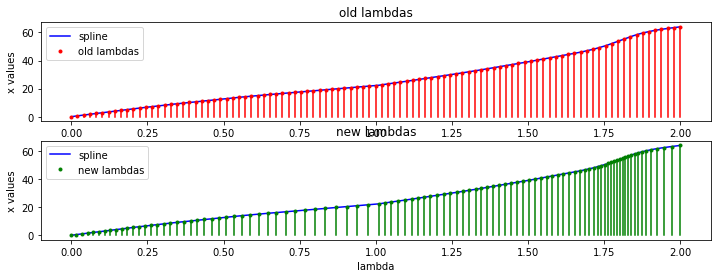

In [98]:

plt.figure(figsize=(12,4))

plt.subplot(2,1,1)
plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
plt.plot(lambda_values, y_spl(np.array(lambda_values)), 'r.', label="old lambdas")
for value in lambda_values:
    plt.plot([value, value], [0, y_spl(value)], 'r-')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')
plt.title('old lambdas')

plt.subplot(2,1,2)
plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
plt.plot(new_lambdas, y_spl(new_lambdas), 'g.', label="new lambdas")
for value in new_lambdas:
    plt.plot([value, value], [0, y_spl(value)], 'g-')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')
plt.title('new lambdas')

print('new_lambdas', new_lambdas)

In [102]:
# Finally, we transform the [0,2] coul+vdW interval back to separate coul_lambdas and vdw_lambdas

new_coul_lambdas = np.minimum(new_lambdas, np.ones(new_lambdas.shape))
new_vdw_lambdas  = np.maximum(new_lambdas, np.ones(new_lambdas.shape)) - 1.0

#print('new_coul_lambdas',new_coul_lambdas)
#print('new_vdw_lambdas',new_vdw_lambdas)

# print out the new lambdas as if they were in an mdp file
outstring = 'coul-lambdas    = ' + " ".join(['%1.4f'%lam for lam in new_coul_lambdas])
print(outstring)

outstring = 'vdw-lambdas     = ' + " ".join(['%1.4f'%lam for lam in new_vdw_lambdas])
print(outstring)


coul-lambdas    = 0.0000 0.0160 0.0354 0.0537 0.0712 0.0901 0.1094 0.1276 0.1461 0.1648 0.1835 0.2023 0.2221 0.2415 0.2630 0.2818 0.3036 0.3241 0.3465 0.3688 0.3919 0.4141 0.4371 0.4608 0.4850 0.5087 0.5341 0.5602 0.5869 0.6151 0.6453 0.6739 0.7036 0.7349 0.7676 0.8007 0.8325 0.8679 0.9042 0.9385 0.9748 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.000